# ML : Tag classification

For this last part we wanted to do some Multilabel classification of the tags based on the text of each questions.
The constraint was to use :
1. `pyspark.ml` library
2. `pyspark.mllib` library
3. A third party library in a spark pipeline

We have been disapointed to learn that pyspark ml and mllib had multi label classification implementation for its algorithm.
Indeed those one can do multi class classification but not multi label. A way to go by this issue would have been to use a string indexer to transform our multlabel into problem one :
Example: if we have three classes $A,B,C$, the stringindexer creates new classes $AB,BC,AC,ABC$, so the model just becomes single label multiclass pb..
There are several problem this method : 
- Dimensionnality : we have a lot more than three tags in the sample. It would have been tramendous computations for really poor results
- A tramendous loose of in information, we would a have lost a part of the label correlation.

After some computation expensive non concluent tests we decided that we will do only multiclass classification on the 10 most used tags (which is often the language associated to the post as we already noticed).


We deciced to only use **20%** of our sample (approx 400 000 rows). Indeed we suffered of of memory overload while fitting our models. 

#### Imports

In [1]:
import os
os.chdir(os.environ['HOME'])

import stack_overflow_functions.DataLoader as data_loader
import stack_overflow_functions.DataTransformation as data_transfo
from stack_overflow_functions.MulticlassEvaluation import evaluation_metrics
from pycountry_convert import country_name_to_country_alpha3
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
import patoolib
import gdown


# Import Spark 
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.sql.types import StructField, StructType, StringType, ArrayType, IntegerType, FloatType
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.model_selection import ParameterGrid
from pyspark import StorageLevel

import pyspark
import sparknlp
from pyspark.sql.window import Window
import pyspark.sql.functions as F
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
import pyspark.ml.feature as sf
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator

seed = 2020

In [2]:
spark = sparknlp.start()
conf = (pyspark
        .SparkConf()
        .set("spark.ui.showConsoleProgress", "true")
       )
sc = pyspark.SparkContext.getOrCreate(conf=conf)
sqlcontext = pyspark.SQLContext(sc)

In [3]:
data_loader.download_data()

All the data folder already exists, we infer that you have already downloaded or extracted the data. If it is not the case delete the data folder (Data/sample) and re run this function.


'Done, data can be found at /home/loic/Data/sample.'

### Clean the data
We use a similar Pipeline that for our feature/target analysis in order to perform ML on it. It was a choice of us to not put it into a module and call it to be clearer on the steps we have done. 
It is also a choice that we do not include those steps in the ML since they are computionnaly costly and unlikely to changed. 

#### Reads the data

In [4]:
%%time
post_dir = "Data/sample/Posts"
posts = (sqlcontext
         .read
         .format("parquet")
         .option("header",True)
         .load(post_dir)
         .sample(False, 0.2, seed)
         .select("Id",
                  F.concat_ws(' ',F.col('Title'),F.col('Body')).alias("full_text"),
                  "Tags"
                )
        )

CPU times: user 20 ms, sys: 2.34 ms, total: 22.4 ms
Wall time: 1min 5s


#### Splits tags

In [5]:
tags_split =tags_split = F.regexp_replace( F.regexp_replace(
    F.regexp_replace(F.col('Tags'), '&lt;', ''), "&gt;", "<split_token>"), " ", "")

udf_drop = F.udf(lambda x: re.sub("'","",str(x[:-1])[1:-1]) if isinstance(x,list) else None,StringType())

posts = (
    posts
    .withColumn('Splitted_tags', tags_split)
    .withColumn('Splitted_tags', F.split(F.col("Splitted_tags"), "<split_token>"))
    .withColumn('Splitted_tags', udf_drop(F.col("Splitted_tags")))
    .withColumn('Splitted_tags', F.split(F.col("Splitted_tags"),","))
    .drop('Tags')
)

#### Clean text

In [6]:
input_col = "full_text"
clean_up_patterns = [
                    "p&gt;"
                    ,"&.*?;\space"
                    ,'&.*?;'                
                    ,"/.*?;"
                    ,"/code"
                    ,"/pre"
                    ,'/p'
                    ,"/a"
                    ,"href="
                    ,"lt;"
                    ,"gt;"
                    ,"[^\w\s]"
                    ,r"\b\d+\b"
                  ]


# Document assembler : Tokenize our text
documentAssembler = DocumentAssembler() \
    .setInputCol(input_col) \
    .setOutputCol('_intermediate_results')

# Document normalizer : Normalize the document
# by lowercasing, removing non utf8 chars
# and remove regex oattern defined
doc_norm = DocumentNormalizer() \
    .setInputCols("_intermediate_results") \
    .setOutputCol(input_col + "_cleaned") \
    .setAction("clean") \
    .setPatterns(clean_up_patterns) \
    .setReplacement(" ") \
    .setPolicy("pretty_all") \
    .setLowercase(True)

# Document tokenizer : allows to remove
# undesired tokens (punctuations etc.)
# prepare the colums for the stopwords 
# remover
tokenizer = Tokenizer() \
    .setInputCols([input_col + "_cleaned"]) \
    .setOutputCol("token") \
    .setSplitChars(['-']) \
    .setContextChars(['(', ')', '?', '!']) \
    .setSplitPattern("'") \
    .setMaxLength(0) \
    .setMaxLength(99999) \
    .setCaseSensitiveExceptions(False)


# StopWordsCleaner : remove 
# the stopwords based on
# a predifined list
Stop_words_cleaner = (
    StopWordsCleaner()
    .pretrained("stopwords_en", "en")
    .setInputCols(["token"])
    .setOutputCol(input_col + "_without_stopwords") 
    .setCaseSensitive(False) 
    .setLazyAnnotator(False)
)

# Lemmatize the text 
# thanks to the lemmatizing tab
# defined above
Lemmatizer_cleaner = (
    Lemmatizer() 
    .setInputCols([input_col + "_without_stopwords"]) 
    .setOutputCol(input_col + "_lemmatized") 
    .setDictionary("./Data/lemmatizer/AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->") 
    .setLazyAnnotator(False)
)


# Creates thepipeline
cleaning_pipeline = (
    Pipeline() 
    .setStages([
        documentAssembler,
        doc_norm,
        tokenizer,
        #Document_cleaner,
        Stop_words_cleaner,
        Lemmatizer_cleaner])
)


posts_ml = (
    cleaning_pipeline
    .fit(posts)
    .transform(posts)
    .select(F.col("Id"),
            F.col(input_col),
            F.col(input_col + "_lemmatized.result"),
            F.col("Splitted_tags")
           )
) 

stopwords_en download started this may take some time.
Approximate size to download 2.9 KB
[OK!]


#### Choose only the 10 most used tags and create a label column

In [7]:
top = 10
tags = (posts_ml
        .select(F.explode('Splitted_tags').alias("tags"))
        .select(F.trim("tags").alias("tags"))
        .groupBy('tags')
        .count()
       ).toPandas()

top = 10
top10 = tags.sort_values(by ="count",ascending = False).head(top).tags.tolist()

posts_ml = (
    posts_ml
    .withColumn('language_deduced',
                data_transfo.udf_detect_language(top10)(F.col('Splitted_tags'))))

#### Creates our final set and save the training set for our scripts

In [8]:
posts_multi_class = (posts_ml
                     .select(F.col('result').alias("text"),
                            data_transfo.udf_detect_language(top10)(F.col('Splitted_tags')).alias("first_label"))
                     .where(F.col('first_label').isNotNull())
                    )

In [9]:
path_to_data = "train/training_sample"
train_split, test_split = posts_multi_class.randomSplit(weights=[0.80, 0.20], seed=seed)
if not os.path.exists(path_to_data): 
    train_split.write.parquet(path_to_data)

train_split.persist(StorageLevel.MEMORY_AND_DISK)
test_split.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[text: array<string>, first_label: string]

###  `pyspark.ml` pipeline 

In the train folder you will find a a script named `train_lr.py` this scripts creates a `pyspark.ml` composed of a : 
- A tf transformer
- An idf transformer
- A label encoder 
- A regularized logistic regression

On this pipeline we test with a grid search (on 4 fold cross validation) the following parameters : 
- "TF IDF Vocabulary size" : [10, 100, 1000, 2500] 
- "Logistic regression L2 penalization : " [0.1, 0.01, 0.001]

We take the best score according to the F1 weighted measure among classes.
The best fitted pipeline has been saved in `/train/models/ml_lr`

You can reproduce this output (if you have time) by running this script using the jupyter command line (**be aware that it is  memory expensive**).
```shell
cd train
python3 -m train_lr
```

**We will analyze the result of this pipeline on the test set**

In [12]:
pipe = PipelineModel.load('train/models/lr/ml_lr')

We want to get the values of the parameters of the best selected model. 
We retrieve the vocabulary size and the penalisation. 

In [116]:
param_dict = pipe.stages[0].extractParamMap()
sane_dict = {}
for k, v in param_dict.items():
    sane_dict[k.name] = v

best_size = sane_dict["vocabSize"]

In [115]:
param_dict = pipe.stages[-1].extractParamMap()
sane_dict = {}
for k, v in param_dict.items():
    sane_dict[k.name] = v

best_reg = sane_dict["regParam"]

In [117]:
print('Best penalisation : {}'.format(best_reg))
print('Best vocabulary size : {}'.format(best_size))

Best penalisation : 0.001
Best vocabulary size : 2500


As we can see, the best regularization is the lowest and the best vocabulary size is the highest possible. According to this values, we could have gone further and put a larger vocabulary size with a smaller penalisation. 

In [59]:
from pyspark.mllib.evaluation import MulticlassMetrics
preds_test = pipe.transform(test_split)

# Compute raw scores on the test set
predictionAndLabels = preds_test.rdd.map(lambda lp: (float(lp.prediction), lp.label))
labels = preds_test.rdd.map(lambda lp: lp.label).distinct().collect()

metrics_results, global_metrics, confusion_matrix = evaluation_metrics(predictionAndLabels, labels)

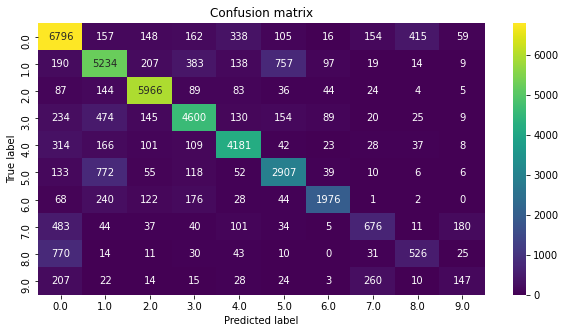

In [41]:
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix,annot=True,cmap="viridis", fmt='g');
plt.ylabel('True label');
plt.xlabel('Predicted label');
plt.title('Confusion matrix') ;

As we saw in a previous notebook, the data are very imbalanced: there are only few css, c++ and jquery (less than 2000) this can explain a poor prediction on them. Despite this observation, we see a clear diagonal of correct predictions. 

The prediction seems to have been doing pretty well. We want to confirm this idea by computing different scores per label: 

In [61]:
metrics_results.insert(0, "Languages", top10, True)
metrics_results = metrics_results.drop('Label',axis=1)
metrics_results

,Languages,Precision,Recall,F1
0,javascript,0.732170,0.813892,0.770871
1,java,0.720242,0.742622,0.731261
2,python,0.876579,0.920395,0.897953
3,c#,0.803915,0.782313,0.792967
4,php,0.816283,0.834698,0.825387
5,android,0.706783,0.709370,0.708075
6,html,0.862129,0.743696,0.798545
7,jquery,0.552739,0.419615,0.477064
8,c++,0.500952,0.360274,0.419124
9,css,0.328125,0.201370,0.249576


We computed the **precision** in order to get how accurate is the prediction of each label.
$$Precision = \frac{TP}{TP + FP}$$
* The most accurate labellings are the one made on one of the 8 most used taggs : their precision is higher than 70%
* The most precise prediction language is Python with a precision of nearly 86%
* The less precise one is CSS : only 33% of accuracy

We also computed the **recall** to see, for each label, how many of the actual label the model captures by predicting this label.  
$$Recall = \frac{TP}{TP+FN}$$
* We notice similar result with recall : the 8 most used tagged are pretty weel captured (more than 70%) by the predicted respective taggs.
* Again, CSS has a really low recall score
* Among the predicted Python, 92% are correctly predicted

We finally get the **f1 score** which seeks a balance between recall and precision. 
$$F1 = 2 \times \frac{precision \times recall}{precision + recall}$$

* The F1-score gives us the same intuition as the recall and precision, with a majority of our languages being very accurately predicted, and CSS being poorly accurate. 

We can explain the high score by supposing that these languages have their own distinct vocabulary with which the algorithm easily discriminate. 

For CSS, we think that its poor score is due to our processing : there are probably html commands that have been removed and that would have been usefull to the prediction. Moreover, we can see on the confusion matrix that CSS is most of the time confused with jquery and javascript, as the three of them are web languages, they probably share some vocabulary and be less distincts. 

In order to have an overall score we compute the followings: 

In [49]:
print('Weighted precision : {}'.format(global_metrics['weightedPrecision']))
print('Weighted recall : {}'.format(global_metrics['weightedRecall']))
print('Weighted F1 measure : {}'.format(global_metrics['weightedFMeasure']))

Weighted precision : 0.7555940323200225
Weighted recall : 0.7618926716676283
Weighted F1 measure : 0.7569377364030256


We also retrieve the weighted recall, weighted precision and weighted F1 measure. Each of them is computed by the formula above : 

$$Weighted\_score = \sum_{l \in L}{p(l) \times score(l)}$$

where ***p(l)*** is the proportion of actual labels ***l*** in the data.

We get **really satisfying scores** : all of them are higher than **75%** !! 

### `pyspark.mlib` algorithm
For this algorithm, we did not go as far as pyspark ml.
Our pseudo pipeline is the following : 
- Transform our df into RDD
- Create a label encoder similar to the pyspark.ml string indexer
- Encode our string into tf idf 
- Use a DecisionTree model in order to classify our languages

We tried different values of maxDepth maxBins in order to find the best weighted F1 score on our test set. Indeed pyspark mllib has no cross validation methods and we did not want to implement such a thing (as it is present in ML library). We do know that it is not a robust method to find hyperparameters (it can possibly overfit the test set). Those chunks are here to show you we can use `pyspark.mllib` API.


In [ ]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF,IDF
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel

train_split_RDD = train_split.rdd.map(tuple)
test_split_RDD = test_split.rdd.map(tuple)

# Matching int: label feature
dic = train_split_RDD.map(lambda x: x[1]).distinct().zipWithIndex().collect()
dic = dict(dic)

train_split_RDD = train_split_RDD.map(lambda x: (dic[x[1]], " ".join(x[0])))
test_split_RDD = test_split_RDD.map(lambda x: (dic[x[1]], " ".join(x[0])))

In [ ]:
numFeatures = 1000
labels_train = train_split_RDD.map(lambda x: x[0])
labels_test = test_split_RDD.map(lambda x: x[0])

tf_train = HashingTF(numFeatures=numFeatures).transform(train_split_RDD.map(lambda x: x[1]))
tf_test =  HashingTF(numFeatures=numFeatures).transform(test_split_RDD.map(lambda x: x[1]))
idf = IDF().fit(tf_train)
tfidf_train = idf.transform(tf_train)
tfidf_test = idf.transform(tf_test)

# Combine using zip
train_tf_idf = labels_train.zip(tfidf_train).map(lambda x: LabeledPoint(x[0], x[1]))
test_tf_idf = labels_test.zip(tfidf_test).map(lambda x: LabeledPoint(x[0], x[1]))

In [ ]:
def evaluate_dt(train_data, test_data, labels_test, maxDepth_value=32, maxBins_value=64):
    """
    Evaluates (Weighted f1 measure) the decision tree on the test set for given params
    returns:
        results (list): Composed of maxDepth_value, maxBins_value, and the weighted f measure
    """
    modelDT = DecisionTree.trainClassifier(train_data, numClasses=10,
                                           categoricalFeaturesInfo={},
                                           impurity='entropy', # or 'gini'
                                           maxDepth=maxDepth_value,
                                           maxBins=maxBins_value)
    predictionsAndLabels = labels_test.zip(model.predict(test_data)).map(lambda x:(x[0], float(x[1])))
    metrics = MulticlassMetrics(predictionsAndLabels)
    return [maxDepth_value, maxBins_value, metrics.weightedFMeasure()]

# maxBins tuning with constant maxDepth
maxBinsParams = [16, 32, 64, 128]
maxDepthParams = [5, 10, 15, 20]
hyper_grid = ParameterGrid({'maxDepth_value': maxDepthParams,
              'maxBins_value': maxBinsParams})

metrics_maxBins = [evaluate_dt(train_tf_idf, test_tf_idf, param['maxDepth_value'], param['maxBins_value']) 
                   for param in hyper_grid]

###  Pyspark/Keras pipeline 

In the train folder you will find a a script named `train_nn.py` this scripts creates a trains a neural network on the 1000 higher tf idf of the corpus for 10 epochs (we wanted to increase those numbers but we were limited by CPU and overall computation power).  

The keras code of this network is :
```python
model = Sequential()
model.add(Dense(256, input_shape=(input_dim,)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(10))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
```
It is basically a small multilayer perceptron with some BatchNorm and dropout for regalurization. 
We use [Elephas](https://github.com/maxpumperla/elephas) to connect our RDD data to Keras.
You can run (if you have time to loose) this module using the jupyter command line (**be aware that it is  time consuming**).
The fitted network has been saved in `/train/models/nn/ml_nn.pk`
```shell
cd train
python3 -m train_nn
```

**We will analyze the result of this pipeline on the test set**

In [19]:
from tensorflow.keras import models
# The model has been stored at a tf.
# keras format
keras_model = models.load_model("train")
keras_model.summary()
# We re put it into a SparkMLlibModel
keras_spark = SparkMLlibModel(model=keras_model, frequency='epoch', mode='asynchronous',parameter_server_mode='socket')

In [77]:
from pyspark.mllib.linalg import Vectors  as MLLibVectors
# We do the same transformations as in the script for the test data
# TF
cv = sf.CountVectorizer(inputCol="text", outputCol="tf_features", vocabSize=input_dim)
# IDF
label_string= sf.StringIndexer(inputCol="first_label", outputCol ="label")
pipeline_dl = Pipeline(stages=[cv, idf, label_string])
test_data = pipeline_dl.fit(train_split).transform(test_split)
test_data = test_data.rdd.map(lambda x :( LabeledPoint(x['label'],MLLibVectors.fromML(x['features']))))

In [ ]:
predictionAndLabels = preds_test.rdd.map(lambda lp: (float(keras_spark.predict(lp[1])), lp[0]))
labels = preds_test.rdd.map(lambda lp: lp.label).distinct().collect()
metrics_results, global_metrics, confusion_matrix = evaluation_metrics(predictionAndLabels, labels)